In this notebook I will consider a number of CNN architectures to predict actions based on images. Initially I will test their accuracy on the training data but later in the notebook I make my final evaluation on their performance on the unseen test data. The best performing model will be saved as task2.mod.

In [1]:
import os 
import random
import numpy as np
import cv2
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Convolution2D
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam as adam
from keras.utils import np_utils

from keras import backend as K

K.set_image_data_format('channels_first')

/Users/ajeffares/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set up some parmaeters for data loading
TRAIN_DIR = './data/'
sample_rate = 1
ROWS = 64
COLS = 64
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    data[i] = image
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

Processed 0 of 64323
Processed 1000 of 64323
Processed 2000 of 64323
Processed 3000 of 64323
Processed 4000 of 64323
Processed 5000 of 64323
Processed 6000 of 64323
Processed 7000 of 64323
Processed 8000 of 64323
Processed 9000 of 64323
Processed 10000 of 64323
Processed 11000 of 64323
Processed 12000 of 64323
Processed 13000 of 64323
Processed 14000 of 64323
Processed 15000 of 64323
Processed 16000 of 64323
Processed 17000 of 64323
Processed 18000 of 64323
Processed 19000 of 64323
Processed 20000 of 64323
Processed 21000 of 64323
Processed 22000 of 64323
Processed 23000 of 64323
Processed 24000 of 64323
Processed 25000 of 64323
Processed 26000 of 64323
Processed 27000 of 64323
Processed 28000 of 64323
Processed 29000 of 64323
Processed 30000 of 64323
Processed 31000 of 64323
Processed 32000 of 64323
Processed 33000 of 64323
Processed 34000 of 64323
Processed 35000 of 64323
Processed 36000 of 64323
Processed 37000 of 64323
Processed 38000 of 64323
Processed 39000 of 64323
Processed 400

In [ ]:
plt.imshow(np.squeeze(data[6]))

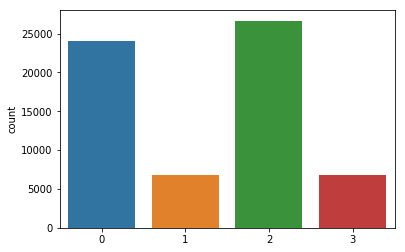

In [3]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
df = pd.DataFrame(labels, columns = ['label'])
sns.countplot(x=df["label"])

In [4]:
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

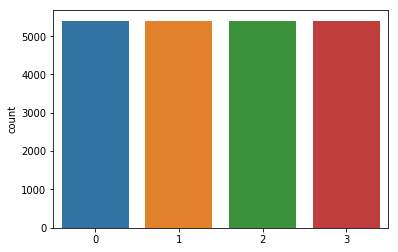

In [5]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

Trying out a couple of model architectures

First architecture:

In [6]:
#first model:

model1 = Sequential()

model1.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(num_classes, activation = 'softmax'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 64, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 4,195,268
Trainable params: 4,195,268
Non-trainable params: 0
_________________________________________________________________


In [7]:
model1.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

In [8]:
epochs = 20
batch_size = 256

history1 = model1.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 16209 samples, validate on 5403 samples
Epoch 1/20
16209/16209 [==============================] - 598s 37ms/step - loss: 1.3266 - acc: 0.3630 - val_loss: 1.1885 - val_acc: 0.4566
Epoch 2/20
16209/16209 [==============================] - 620s 38ms/step - loss: 1.1662 - acc: 0.4503 - val_loss: 1.0866 - val_acc: 0.4995
Epoch 3/20
16209/16209 [==============================] - 408s 25ms/step - loss: 1.1048 - acc: 0.4865 - val_loss: 1.0549 - val_acc: 0.5038
Epoch 4/20
16209/16209 [==============================] - 1575s 97ms/step - loss: 1.0571 - acc: 0.5048 - val_loss: 1.0249 - val_acc: 0.5197
Epoch 5/20
16209/16209 [==============================] - 1138s 70ms/step - loss: 1.0312 - acc: 0.5114 - val_loss: 1.0066 - val_acc: 0.5253
Epoch 6/20
16209/16209 [==============================] - 495s 31ms/step - loss: 1.0055 - acc: 0.5251 - val_loss: 0.9883 - val_acc: 0.5292
Epoch 7/20
16209/16209 [==============================] - 605s 37ms/step - loss: 0.9860 - acc: 0.5331 - val_loss: 0

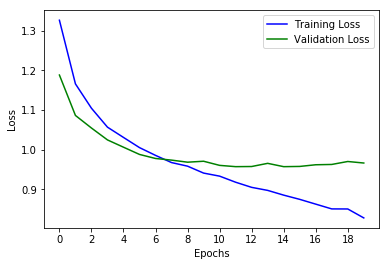

In [9]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss1, 'blue', label='Training Loss')
plt.plot(val_loss1, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

Second architecture:

In [10]:
model2 = Sequential()
model2.add(Flatten(input_shape=(CHANNELS, ROWS, COLS)))
model2.add(Dense(16))
model2.add(Activation('relu'))
model2.add(Dense(16))
model2.add(Activation('relu'))
model2.add(Dense(16))
model2.add(Activation('relu'))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                65552     
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

In [11]:
model2.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

In [12]:
epochs = 20
batch_size = 256

history2 = model2.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 16209 samples, validate on 5403 samples
Epoch 1/20
16209/16209 [==============================] - 3s 192us/step - loss: 1.3683 - acc: 0.2975 - val_loss: 1.3436 - val_acc: 0.2837
Epoch 2/20
16209/16209 [==============================] - 2s 120us/step - loss: 1.2551 - acc: 0.3838 - val_loss: 1.2236 - val_acc: 0.3774
Epoch 3/20
16209/16209 [==============================] - 2s 103us/step - loss: 1.2092 - acc: 0.4295 - val_loss: 1.2309 - val_acc: 0.4285
Epoch 4/20
16209/16209 [==============================] - 2s 108us/step - loss: 1.1709 - acc: 0.4667 - val_loss: 1.1608 - val_acc: 0.4609
Epoch 5/20
16209/16209 [==============================] - 2s 137us/step - loss: 1.1326 - acc: 0.4808 - val_loss: 1.1255 - val_acc: 0.4670
Epoch 6/20
16209/16209 [==============================] - 2s 97us/step - loss: 1.0850 - acc: 0.4923 - val_loss: 1.0748 - val_acc: 0.5064
Epoch 7/20
16209/16209 [==============================] - 1s 91us/step - loss: 1.0492 - acc: 0.5048 - val_loss: 1.0552 - val

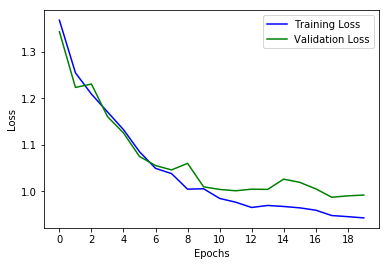

In [13]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss2, 'blue', label='Training Loss')
plt.plot(val_loss2, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

Third architecture:

In [14]:
model3 = Sequential()
model3.add(Conv2D(32, (8, 8), input_shape=(CHANNELS, ROWS, COLS), strides=(4, 4)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (4, 4), strides=(2, 2)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3), strides=(1, 1)))
model3.add(Activation('relu'))
model3.add(Flatten())
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 15, 15)        2080      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 6, 6)          32832     
_________________________________________________________________
activation_6 (Activation)    (None, 64, 6, 6)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 4, 4)          36928     
_________________________________________________________________
activation_7 (Activation)    (None, 64, 4, 4)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
__________

In [15]:
model3.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

In [16]:
epochs = 20
batch_size = 256

history3 = model3.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 16209 samples, validate on 5403 samples
Epoch 1/20
16209/16209 [==============================] - 41s 3ms/step - loss: 1.1971 - acc: 0.4214 - val_loss: 1.0612 - val_acc: 0.4875
Epoch 2/20
16209/16209 [==============================] - 41s 2ms/step - loss: 1.0382 - acc: 0.4992 - val_loss: 1.0237 - val_acc: 0.4927
Epoch 3/20
16209/16209 [==============================] - 41s 3ms/step - loss: 1.0048 - acc: 0.5169 - val_loss: 1.0032 - val_acc: 0.5156
Epoch 4/20
16209/16209 [==============================] - 41s 3ms/step - loss: 0.9801 - acc: 0.5286 - val_loss: 0.9893 - val_acc: 0.5127
Epoch 5/20
16209/16209 [==============================] - 41s 3ms/step - loss: 0.9606 - acc: 0.5366 - val_loss: 0.9811 - val_acc: 0.5232
Epoch 6/20
16209/16209 [==============================] - 206s 13ms/step - loss: 0.9417 - acc: 0.5437 - val_loss: 0.9750 - val_acc: 0.5290
Epoch 7/20
16209/16209 [==============================] - 49s 3ms/step - loss: 0.9247 - acc: 0.5560 - val_loss: 0.9775 - val_ac

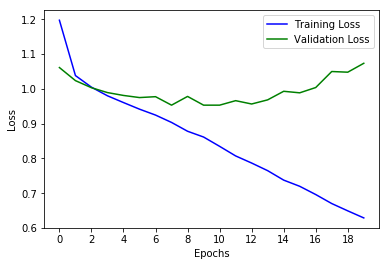

In [17]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss3, 'blue', label='Training Loss')
plt.plot(val_loss3, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

Fourth architecture


In [18]:
model4 = Sequential()

model4.add(Conv2D(32, (8,8),strides = (4,4), activation='relu', input_shape=(CHANNELS, ROWS, COLS)))
model4.add(Dropout(0.5))
model4.add(Conv2D(64, (4,4),strides = (2,2), activation='relu'))
model4.add(Dropout(0.5))
model4.add(Conv2D(64, (3,3),strides = (1,1), activation='relu'))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 15, 15)        2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 6, 6)          32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 6, 6)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 4, 4)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               131200    
__________

In [19]:
model4.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

In [20]:
epochs = 20
batch_size = 256

history4 = model4.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 16209 samples, validate on 5403 samples
Epoch 1/20
16209/16209 [==============================] - 44s 3ms/step - loss: 1.3876 - acc: 0.2491 - val_loss: 1.3865 - val_acc: 0.2421
Epoch 2/20
16209/16209 [==============================] - 43s 3ms/step - loss: 1.3866 - acc: 0.2471 - val_loss: 1.3864 - val_acc: 0.2421
Epoch 3/20
16209/16209 [==============================] - 43s 3ms/step - loss: 1.3864 - acc: 0.2534 - val_loss: 1.3862 - val_acc: 0.2452
Epoch 4/20
16209/16209 [==============================] - 42s 3ms/step - loss: 1.3867 - acc: 0.2483 - val_loss: 1.3856 - val_acc: 0.2517
Epoch 5/20
16209/16209 [==============================] - 44s 3ms/step - loss: 1.3131 - acc: 0.3350 - val_loss: 1.1667 - val_acc: 0.4203
Epoch 6/20
16209/16209 [==============================] - 44s 3ms/step - loss: 1.1690 - acc: 0.4411 - val_loss: 1.0693 - val_acc: 0.4921
Epoch 7/20
16209/16209 [==============================] - 42s 3ms/step - loss: 1.1082 - acc: 0.4712 - val_loss: 1.0476 - val_acc:

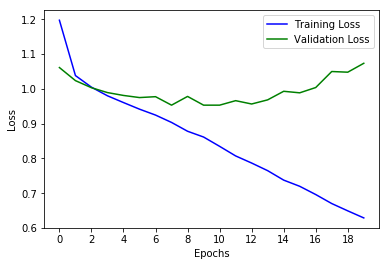

In [21]:
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss3, 'blue', label='Training Loss')
plt.plot(val_loss3, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [22]:
A = {"Model 1": model1, " Model 2": model2, "Model 3": model3, "Model 4": model4}

In [23]:
# Evaluating the performance of all of the classifiers 
accuracy_table = pd.DataFrame(index = ["Accuracy"], columns=A.keys())
maximum = 0
for keys, items in A.items():
    pred = items.predict_classes(test)
    print("Confusion Matrix for", keys)
    print(metrics.confusion_matrix(test_labels, pred))
    print("Accuracy for", keys)
    X = metrics.accuracy_score(pred, test_labels)
    print(X, "\n")
    if X>maximum:
        maximum = X
        classifier = items
        name = keys
    accuracy_table.loc["Accuracy",keys] = X

Confusion Matrix for  Model 2
[[ 851  512 3168  322]
 [  99  901  360   22]
 [ 861  585 3360  450]
 [ 182   58  323  811]]
Accuracy for  Model 2
0.46039642440730666 

Confusion Matrix for Model 1
[[1949  527 1713  664]
 [ 205  959  188   30]
 [1950  595 1918  793]
 [ 207   24  163  980]]
Accuracy for Model 1
0.45130198212203654 

Confusion Matrix for Model 4
[[3382  450  432  589]
 [ 432  913   26   11]
 [3498  569  446  743]
 [ 360   35   57  922]]
Accuracy for Model 4
0.440186552662262 

Confusion Matrix for Model 3
[[1478  767 1756  852]
 [ 133 1032  172   45]
 [1598  847 1875  936]
 [ 138   20  160 1056]]
Accuracy for Model 3
0.4229304314030315 



In [24]:
accuracy_table

,Model 2,Model 1,Model 4,Model 3
Accuracy,0.460396,0.451302,0.440187,0.42293


In [25]:
print("Best classifier is:", name, "with accuracy of:", maximum)
filepath = "task2.mod"
classifier.save(filepath)

Best classifier is:  Model 2 with accuracy of: 0.46039642440730666
